### COM361 &mdash; Introdução a Otimização &mdash; 2022, Prof. Amit ###

# Event triggered social media chatter model - Julia implementation #

#### Gabriel José Souza e Silva (gabriel.jsss@poli.ufrj.br), Matheus Marinatto (marinattomatheus@poli.ufrj.br)


### Contents ###

1. Introduction and problem description
2. Mathmatical modeling

## 1. Introduction and problem description ##

This project's goal is to describe and explore a social marketing-based model for information spread, testing different control techniques so to determine which one provides better results. An important constraint for most marketing campaigns nowadays is the advertising cost, therefore a key goal for dispersing a message is to do that as efficiently and possible respecting budget and time constraints. From that, many optimization problems can be formulated. The following question, described in [1] gives the reason for such models to exist:

> At a high level, how does an organization sell to someone? Typically, individuals or groups (like marketing agencies) are enlisted as message spreaders who broadcast that information in a variety of formats including billboards, social media posts, and television advertisements.
> 

So in order to sell, it's necessary to spread information and the further question would be **how to maximize sells (and information spread) while minimizing costs**.

In [1], the approach to design an advertising model starts from the well established Vidale-Wolfe marketing model with some tweaks to better handle the social media dynamics. Quoting [2]:

> The Vidale-Wolfe marketing model is a first-order, linear, nonhomogeneous ordinary differential equation (ODE) where the forcing term is proportional to advertising expenditure. With an initial response in sales as the initial condition, the solution of the initial value problem is straightforward for a first undergraduate ODE course.
> 

Mathematically, this model is described as follows:

 $\frac{dS(t)}{dt} = \beta u(t)[M(t) - S(t)] - \delta S(t)$

where

- S(t) → Sales at time t;
- M(t) → Market size at time t;
- $\beta$ → Advertising constant;
- $\delta$ → Rate of brand sale decay;
- $u(t)$ → Control action at time t.

Most of the terms above are self-explanatory but $\beta$, which is described in [1] as “[…] the rate of decay of brand sale given no active advertising.”

From that, the Event-triggered Social Media Chatter Model is derived by doing the following:

1. Normalizing Vidale-Wolfe's model by setting $M(t) = 1$;
2. Breaking $\beta$ into two other constants:
    1. $\beta_1$ → the social marketing campaign constant;
    2. $\beta_2$ → the social interaction constant;
3. Generalizing the sales term $S(t)$ to an information spread value $X_t$.

In [1] the meaning of these constants is explained in the following paragraph

> The effectiveness of social marketing is affected by dynamic resource spending and promotion over the network to convince people to purchase a product, uphold a social or political movement, or join in an activity. The social marketing constant can be associated with a traditional advertising campaign or an event that triggers similar social media interest. Once people become exposed to an advertisement and decide to share the message, the social interaction constant may be viewed as the natural tendency of the social media network to advertise internally through posts, tweets, and likes without external influences and advertising.
> 

The final mathematical model is 

$$
dX_t = \beta_1 u(t)[1 - X_t] + \beta_2 [1 - X_t] X_t - \delta X_t
$$

or visually 

![Model](./assets/model.png)

The final definition to be presented is the concept of socio-equilibrium threshold. It basically describes the equilibrium level of social media chatter after the control (promotion) goes to 0 or mathematically

$$
X_{eqb} = 1 - \frac{\delta}{\beta_2}
$$

In [1], $\beta_2$ is multiplied by a factor k, but in this project the value of k will be embedded in $\beta_2$. Finally, the “[…] goal of social media marketing is to increase peoples’ attention and interest beyond the natural equilibrium point through the control action of spending resources on ads…” and at the same time minimizing the associated costs.



## 2. Mathematical model ##

During a marketing campaign, **the goal is to achieve social craze status as fast as possible while keeping costs as low as possible**. From that the optimization problem will be derived. The cost function for the Event-triggered Social Media Chatter Model is defined in [1] as 

$$
J = \int_{0}^{t_f}  [u^2(t) + (x-x_d)^2 + \lambda] dt
$$

where 

- $\lambda$  → weight placed on time. Meaning the importance of how long it takes to get to equilibrium;
- $x_d$ → desired amount of activity.

when there's no need to maintain $x_d$, $u(t)= 0$. Now the mentioned equations will be discretized, so they can be used in future simulations:

- Event-triggered Social Media Chatter Model:

$$
x(t+1) - x(t) = \beta_1 u(t)[1 - x(t)] + \beta_2 [1 - x(t)] x(t) - \delta x(t)
$$

- Cost function:

$$
J = \sum_{t=0}^{T_F}(u^2(t) + (x(t) - x_d(t))^2 + \lambda)
$$

- Equilibrium point:

$$
X_{eqb} = 1 - \frac{\delta}{\beta_2}
$$

Gathering these equations, the optimization problem can be formulated as

$$
\begin{aligned}\underset{u}{\text{minimize}}\qquad& J(u, x) \\\text{subjected to:}\qquad& u_i \ge 0 && i=1,\dots,m\\& x_{i+1} = x_i + \beta_1 u_i[1 - x_i] + \beta_2 [1 - x_i] x_i - \delta x_i \\& x_i \ge 0\end{aligned}
$$

More constraints may be added according to the control technique used. The constants used are defined in the cell below, following the same as used in the snipet on page 151 of [1].

The first formulation proposed tries to get to the equibilibrium minimizing the associated expenses. However, another goal could be to get to the $X_{eqb}$ as fast as possible. For this second goal proposed in this project, the objective function can be reduced to

$$
J = \sum_{t=0}^{T_F}(x(t) - X_{eqb})^2
$$


In [8]:
#dependencies

import Pkg; 
Pkg.add("JuMP");
Pkg.add("Clp");
Pkg.add("PyPlot");
Pkg.add("Ipopt");

@time using Clp;
@time using JuMP;
@time using PyPlot;
@time using Ipopt;


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


  0.000369 seconds (180 allocations: 13.742 KiB)
  0.000285 seconds (180 allocations: 13.742 KiB)
  0.000284 seconds (180 allocations: 13.742 KiB)


  0.000296 seconds (180 allocations: 13.742 KiB)


In [57]:
δ = 0.1; #forgetting factor
β1 = 0.1; #spreading constant
β2 = 0.15; #social spreading
λ = 1; #time cost weight
xEquilibrium = 1-(δ/β2);
ρβ1 = 0.02;
ρβ2 = 0.03;
ρδ = 0.025;

function getTimeXeqReached(x)
    for t in 1:numberOfIterations
        if x[t] >= 0.33
            return t;
        end
    end
    return 0;
end;

<h3> 3.1 Optimal control </h3>

In [43]:
function optimalControl()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    numberOfIterations = 100;
    @variable(m, xOptimalControl[1:numberOfIterations] >= 0);        
    @variable(m, uOptimalControl[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(m, xOptimalControl[t+1] == xOptimalControl[t] + β1*uOptimalControl[t]*(1 - xOptimalControl[t]) + β2*(1 - xOptimalControl[t])*xOptimalControl[t] - δ*xOptimalControl[t]);
    end

    @constraint(m, sum(xOptimalControl) >= 0);
    @constraint(m, sum(uOptimalControl) >= 0);
    @constraint(m, xOptimalControl[1] == 0) #initial point


    @objective(m, Min, sum(
        uOptimalControl .^2 .+ (xOptimalControl .- xEquilibrium).^2 .+ λ
    ));
    optimize!(m);
    return JuMP.objective_value.(m), JuMP.value.(xOptimalControl), JuMP.value.(uOptimalControl), sum(JuMP.value.(uOptimalControl))
end;

101.08874588996284
[-2.818722160738183e-40, 0.03143742192612366, 0.05916806739835122, 0.08380467839066263, 0.10582232339851363, 0.12559605468638763, 0.1434268599765247, 0.15955993436529997, 0.1741977870907215, 0.18750979834242631, 0.19963928951106827, 0.21070882249925718, 0.22082421915895611, 0.23007764372431538, 0.2385499913558608, 0.24631275755364787, 0.25342951558751126, 0.2599570954456325, 0.2659465337092212, 0.2714438463052314, 0.27649066331001065, 0.28112475553555605, 0.28538047559871765, 0.2892891309004579, 0.29287930196352224, 0.29617711655897844, 0.299206487752443, 0.30198932224134356, 0.3045457040034386, 0.3068940572357245, 0.30905129175803814, 0.31103293343145, 0.3128532416557598, 0.31452531563096203, 0.3160611907699571, 0.3174719264153173, 0.31876768582721826, 0.3199578092616985, 0.321050880839748, 0.3220547898118308, 0.32297678674430996, 0.3238235350899966, 0.32460115855171345, 0.3253152846030484, 0.32597108449259987, 0.32657331002560824, 0.3271263273888703, 0.327634148260

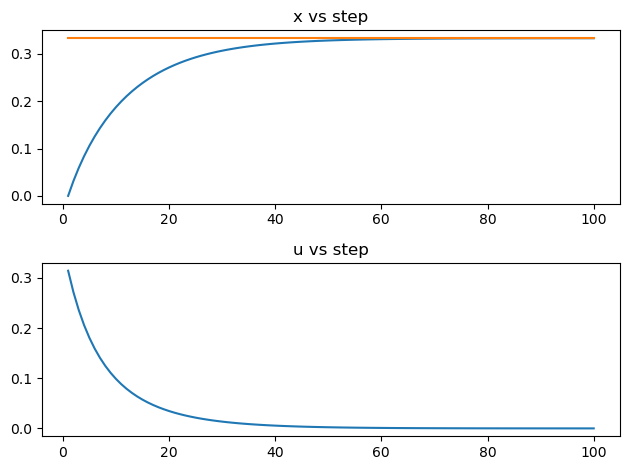

In [44]:
####### exporting variables for further analysis ########
costOptimalControlResult, xOptimalControlResult, uOptimalControlResult, controlAmountOptimalControlResult = optimalControl()
println(costOptimalControlResult);
println(xOptimalControlResult);
println(uOptimalControlResult);
println(controlAmountOptimalControlResult);

##### simple plot #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, numberOfIterations), transpose(JuMP.value.(xOptimalControl)));
plt.plot(range(1, numberOfIterations), xEquilibrium .* ones(numberOfIterations));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, numberOfIterations), transpose(JuMP.value.(uOptimalControl)));

fig.tight_layout();
show()
gcf()

<h3> 3.2 Optimal control with max instantaneous and total control input </h3>

In [79]:
function optimalControlWithCostConstraints()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    numberOfIterations = 100;
    @variable(m, xOptimalControlLimitedCosts[1:numberOfIterations] >= 0);        
    @variable(m, uOptimalControlLimitedCosts[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(m, xOptimalControlLimitedCosts[t+1] == xOptimalControlLimitedCosts[t] + β1*uOptimalControlLimitedCosts[t]*(1 - xOptimalControlLimitedCosts[t]) + β2*(1 - xOptimalControlLimitedCosts[t])*xOptimalControlLimitedCosts[t] - δ*xOptimalControlLimitedCosts[t]);
    end

    @constraint(m, uOptimalControlLimitedCosts[numberOfIterations] == 0);
    @constraint(m, sum(xOptimalControlLimitedCosts) >= 0);
    @constraint(m, sum(uOptimalControlLimitedCosts) >= 0);

    @constraint(m, xOptimalControlLimitedCosts[1] == 0) #prevent explosion
    @constraint(m, uOptimalControlLimitedCosts[1] <= 1) #prevent explosion

    ##### introduce max possible control input ###########################
    @constraint(m, sum(uOptimalControlLimitedCosts) <= 1.8)
    @constraint(m, uOptimalControlLimitedCosts .<= 0.1)
    ##### introduce max possible control input ###########################

    advertisingCost = @expression(m, sum(uOptimalControlLimitedCosts .^2 .+ (xOptimalControlLimitedCosts .- xEquilibrium).^2 .+ λ)) #prevent explosion
    @objective(m, Min, advertisingCost);
    optimize!(m);

    return JuMP.objective_value.(m), JuMP.value.(xOptimalControlLimitedCosts), JuMP.value.(uOptimalControlLimitedCosts), sum(uOptimalControlLimitedCostsResult);
end;

101.43442942075757
[5.807152217107358e-40, 0.010000000736685617, 0.020385001454448617, 0.03113806990674576, 0.04223815636670494, 0.053660073840459586, 0.06537456666881197, 0.0773484745256171, 0.08954499566016587, 0.1019240494669187, 0.11444273427181618, 0.12705587182708886, 0.13971662564281115, 0.1523771758383593, 0.1649894028539156, 0.17642557730372865, 0.18661852043766727, 0.19570480918030417, 0.20380072101018226, 0.21100578983753202, 0.21740556785558346, 0.2230737923643937, 0.2280741017637171, 0.23246140622889294, 0.2362829964803067, 0.23972286603215928, 0.24308896373191924, 0.24637958211435992, 0.24959313112969472, 0.25272828154520005, 0.2557839607833515, 0.2587593459475254, 0.26165385533658014, 0.2644671387920271, 0.26719906708730967, 0.26984972053662937, 0.27241937698782626, 0.2749084993546372, 0.27731772283462525, 0.2796478419493319, 0.2818997975326613, 0.28407466378231044, 0.2861736354774327, 0.2881980154538918, 0.2901492024166531, 0.2920286791572631, 0.29383800123315307, 0.295

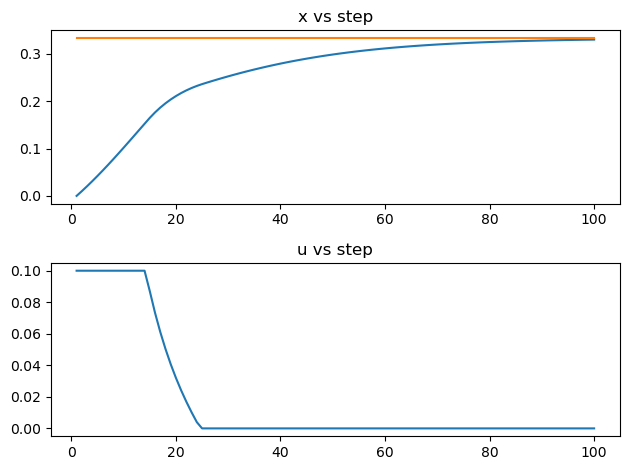

In [80]:
####### exporting variables for further analysis ########
costOptimalControlLimitedCostsResult, xOptimalControlLimitedCostsResult, uOptimalControlLimitedCostsResult, controlAmountOptimalControlLimitedCostsResult = optimalControlWithCostConstraints();
println(costOptimalControlLimitedCostsResult);
println(xOptimalControlLimitedCostsResult);
println(uOptimalControlLimitedCostsResult);
println(controlAmountOptimalControlLimitedCostsResult);

##### simple plotting #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, numberOfIterations), transpose(JuMP.value.(xOptimalControlLimitedCosts)));
plt.plot(range(1, numberOfIterations), xEquilibrium .* ones(numberOfIterations));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, numberOfIterations), transpose(JuMP.value.(uOptimalControlLimitedCosts)));

fig.tight_layout();
show()
gcf()

<h3> 3.3 Optimal control without cost concerns </h3>

In the problems formulated above, a maximum advertising time has been established and the goal is to get to the $X_{eqb}$ using the minum amount of resources (control input). However, another problem could be formulated with the goal to reach $X_{eqb}$ and fast as possible regarless of the cost.

In [82]:
function fastestEquilibriumControl()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    numberOfIterations = 100;
    @variable(m, xFastestEquilibrium[1:numberOfIterations] >= 0);        
    @variable(m, uFastestEquilibrium[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(m, xFastestEquilibrium[t+1] == xFastestEquilibrium[t] + β1*uFastestEquilibrium[t]*(1 - xFastestEquilibrium[t]) + β2*(1 - xFastestEquilibrium[t])*xFastestEquilibrium[t] - δ*xFastestEquilibrium[t]);
    end

    @constraint(m, uFastestEquilibrium[numberOfIterations] == 0);
    @constraint(m, xFastestEquilibrium[numberOfIterations] == xEquilibrium);
    @constraint(m, sum(xFastestEquilibrium) >= 0);
    @constraint(m, sum(uFastestEquilibrium) >= 0);

    @constraint(m, xFastestEquilibrium[1] == 0) #prevent explosion
    @constraint(m, uFastestEquilibrium .<= 0.1) #prevent explosion

    @objective(m, Min, sum(
        sum((xFastestEquilibrium .- xEquilibrium).^ 2)
    ));
    optimize!(m);

    return JuMP.objective_value.(m), JuMP.value.(xFastestEquilibrium), JuMP.value.(uFastestEquilibrium), sum(uFastestEquilibriumResult);
end;

1.1287786900059669
[3.7489278434030316e-42, 0.010000000914057257, 0.020385001842951563, 0.031138070546259118, 0.04223815730502341, 0.0536600751359588, 0.06537456839454697, 0.07734847677589778, 0.08954499856168169, 0.10192405319891759, 0.11444273910638592, 0.12705587822168138, 0.1397166345067561, 0.15237718972580927, 0.1649894565952891, 0.17750580714480457, 0.18987979301832525, 0.20206683459710909, 0.214024857246354, 0.2257148555779517, 0.23710137018720223, 0.24815286559186028, 0.258842002760866, 0.2691458043372428, 0.2790457151226628, 0.28852756433172444, 0.29758143933047604, 0.30620148286998594, 0.31438562688629595, 0.3221352736915778, 0.32945489791439153, 0.33324242964152984, 0.33325435310645074, 0.3332622199922162, 0.33326846995020915, 0.3332737764543353, 0.33327843027129483, 0.333282587961871, 0.33328634607088775, 0.3332897698944788, 0.333292906642185, 0.3332957921990959, 0.33329845491343996, 0.333300917865674, 0.3333032003034099, 0.3333053185902248, 0.33330728685703576, 0.33330911

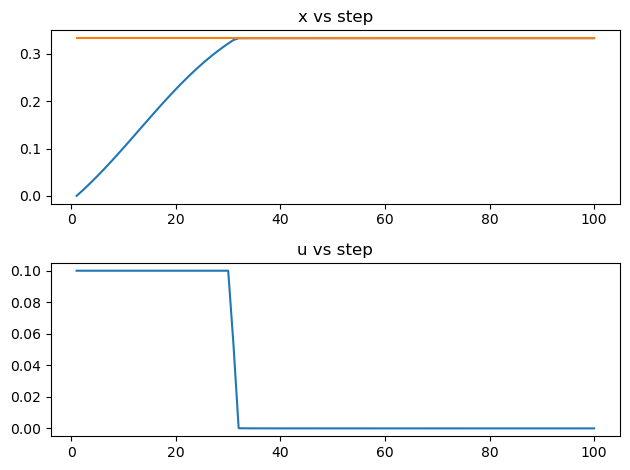

In [83]:
####### exporting variables for further analysis ########
costFastestEquilibriumResult, xFastestEquilibriumResult, uFastestEquilibriumResult, controlAmountFastestEquilibriumResult = fastestEquilibriumControl()
println(costFastestEquilibriumResult);
println(xFastestEquilibriumResult);
println(uFastestEquilibriumResult);
println(controlAmountFastestEquilibriumResult);

##### plotting #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, numberOfIterations), transpose(JuMP.value.(xFastestEquilibrium)));
plt.plot(range(1, numberOfIterations), xEquilibrium .* ones(numberOfIterations));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, numberOfIterations), transpose(JuMP.value.(uFastestEquilibrium)));

fig.tight_layout();
show()
gcf()


<h3> 3.4 Model predective control </h3>

In [84]:
function MPC()
    t = collect(2:100) #eixo x
    loopCount = 100
    uMPC = Array{Float64}(undef, loopCount)
    xMPC = Array{Float64}(undef, loopCount)
    uMPC[1] = 0
    xMPC[1] = 0

    for i in t
        ################ optimization routine #####################
        m = Model(Ipopt.Optimizer);
        set_silent(m);
        movingTimeHorizon = 10; #prediction window
        @variable(m, xMPCLocal[1:movingTimeHorizon] >= xMPC[i-1]);        
        @variable(m, uMPCLocal[1:movingTimeHorizon] >= 0);
        @constraint(m, xMPCLocal[1] == xMPC[i]) #initial point
        @constraint(m, xMPCLocal[10] == xEquilibrium) #initial point
        @constraint(m, uMPCLocal[1] == uMPC[i]) #initial point
        @constraint(m, uMPCLocal .<= 0.1)
        for t in 1:movingTimeHorizon-1
            @constraint(m, xMPCLocal[t+1] == xMPCLocal[t] + β1*uMPCLocal[t]*(1 - xMPCLocal[t]) + β2*(1 - xMPCLocal[t])*xMPCLocal[t] - δ*xMPCLocal[t]);
        end
        @objective(m, Min, sum(
            uMPCLocal .* uMPCLocal .+ (xMPCLocal .- xEquilibrium).^2 .+ λ
        ));
        optimize!(m);
        #############################################################
        uMPC[i] = JuMP.value.(uMPCLocal)[2]
        xMPC[i] = xMPC[i - 1] + β1*uMPC[i - 1]*(1 - xMPC[i - 1]) + β2*(1 - xMPC[i - 1])*xMPC[i - 1] - δ*xMPC[i - 1]
    end

    return JuMP.objective_value.(m), xMPC, uMPC, sum(uMPCResult);
end;

101.43442942075757
[0.0, 0.0, 0.01000000099868024, 0.020385002024324844, 0.031138070837779364, 0.04223815771891406, 0.05366007568828731, 0.06537456910241679, 0.07734847765687619, 0.08954499963484423, 0.10192405448446289, 0.11444274062747162, 0.12705588000295542, 0.13971663657856248, 0.15237719211235365, 0.16498945934205317, 0.17750581029561022, 0.18987979662555782, 0.20206683872462228, 0.21402486197359472, 0.2257148610059425, 0.2371013764474497, 0.24815287286005241, 0.25884201127876816, 0.26914581444939667, 0.2790457273416028, 0.2870423765588757, 0.293668625925108, 0.2993453644162042, 0.3042463857975898, 0.30848898064792496, 0.31216827491577903, 0.3153616227065969, 0.3181429955346933, 0.3205669327291344, 0.32268164825446793, 0.3249151693672486, 0.3265026598686252, 0.3282285246581623, 0.3297219187201048, 0.330934360328611, 0.3318678947805426, 0.33253275427947676, 0.33292330237156453, 0.33312827521826155, 0.33323950288999116, 0.33329399519732783, 0.3333187023551317, 0.3333289287694286, 0

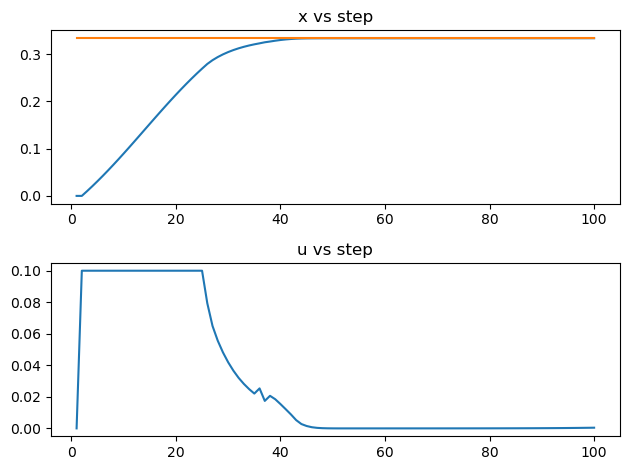

In [85]:
costMPCResult,xMPCResult,uMPCResult,controlAmountMPCResult = MPC();
println(costMPCResult);
println(xMPCResult);
println(uMPCResult);
println(controlAmountMPCResult);

clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, loopCount), transpose(xMPC));
plt.plot(range(1, loopCount), xEquilibrium .* ones(loopCount));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, loopCount), transpose(uMPC));

fig.tight_layout();
show()
gcf()

<h3> 3.5 Uncertanties </h3>

In [76]:
function optimalControlWihUncertanties()
    m = Model(Ipopt.Optimizer);
    set_silent(m);
    numberOfIterations = 300;
    @variable(m, xOptimalControl[1:numberOfIterations] >= 0);        
    @variable(m, uOptimalControl[1:numberOfIterations] >= 0);
    @variable(m, t1[1:numberOfIterations] >= 0);
    @variable(m, t2[1:numberOfIterations] >= 0);
    @variable(m, t3[1:numberOfIterations] >= 0);

    for t in 1:numberOfIterations-1
        @constraint(
            m, 
            xOptimalControl[t+1] == xOptimalControl[t] 
            + β1*uOptimalControl[t]*(1 - xOptimalControl[t]) - ρβ1*(β1*uOptimalControl[t]*(1 - xOptimalControl[t]))
            + β2*(1 - xOptimalControl[t])*xOptimalControl[t] - ρβ2*(1 - xOptimalControl[t])*xOptimalControl[t] 
            - (δ*xOptimalControl[t] - ρδ*(δ*xOptimalControl[t]))
        );
    end

    @constraint(m, sum(xOptimalControl) >= 0);
    @constraint(m, sum(uOptimalControl) >= 0);
    @constraint(m, xOptimalControl[1] == 0) #initial point
    @constraint(m, xOptimalControl[300] == xEquilibrium) #final point

    @objective(m, Min, sum(
        uOptimalControl .^2 .+ (xOptimalControl .- xEquilibrium).^2 .+ λ
    ));
    optimize!(m);
    return JuMP.objective_value.(m), JuMP.value.(xOptimalControl), JuMP.value.(uOptimalControl), sum(JuMP.value.(uOptimalControl))
end;

19.063147508581416
[1.0358186023025775e-41, 0.030558169946600624, 0.05743458534283341, 0.0811950748394246, 0.10228992199426318, 0.12108346878687584, 0.13787491388079734, 0.15291321280449968, 0.1664079423387686, 0.17853735111762672, 0.18945441543098876, 0.1992914594357697, 0.20816372795340488, 0.21617218529667762, 0.2234057352992773, 0.2299430035259692, 0.23585378461269388, 0.2412002306822882, 0.24603783740045954, 0.2504162701911093, 0.25438006286065407, 0.2579692133104863, 0.2612196953924623, 0.26416390175281734, 0.26683102933638614, 0.2692474168132168, 0.2714368413464686, 0.2734207807001922, 0.2752186455827867, 0.2768479862588849, 0.27832467678148065, 0.2796630796543362, 0.2808761932999287, 0.2819757843562266, 0.2829725065381391, 0.2838760075626727, 0.28469502544005976, 0.285437475268254, 0.286110527528956, 0.2867206787648488, 0.28727381541620833, 0.2877752715074877, 0.2882298807985206, 0.2886420239487281, 0.289015671184653, 0.2893544209100351, 0.28966153465249567, 0.2899399687008702,

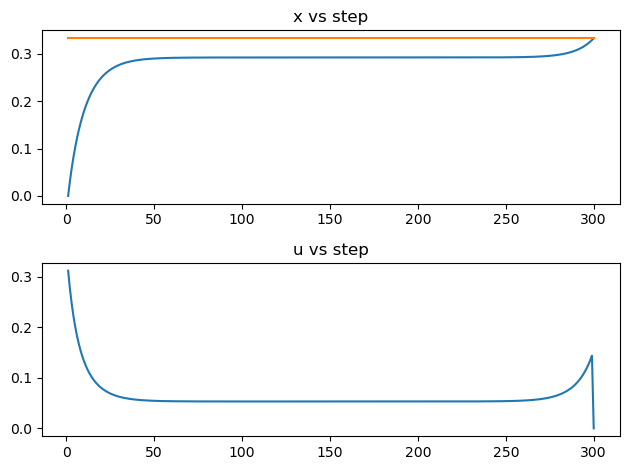

In [77]:
####### exporting variables for further analysis ########
costOptimalControlWithUncertantiesResult, xOptimalControlWithUncertantiesResult, uOptimalControlWithUncertantiesResult, controlAmountOptimalControlWithUncertantiesResult = optimalControlWihUncertanties()
println(controlAmountOptimalControlWithUncertantiesResult)
println(xOptimalControlWithUncertantiesResult)

##### simple plot #######
clf(); #required for vscode on mac 
fig = plt.figure();

ax1 = fig.add_subplot(2, 1, 1);
ax1.title.set_text("x vs step");
plt.plot(range(1, 300), transpose(JuMP.value.(xOptimalControlWithUncertantiesResult)));
plt.plot(range(1, 300), xEquilibrium .* ones(300));

ax2 = fig.add_subplot(2, 1, 2);
ax2.title.set_text("u vs step");
plt.plot(range(1, 300), transpose(JuMP.value.(uOptimalControlWithUncertantiesResult)));

fig.tight_layout();
show()
gcf()

## 4. Results and discussion ##

| Control      | Control amount           | Time to reach equilibrium  |
| -------------|---------------| -----|
| Optimal control                      | 2.776115114183729 | 55 |
| Optimal control with cost limit      | 1.8000000059172825| 98 |
| No cost concerns                     | 3.0541570417764654| 32 |
| Predictive control                   | 2.9671206150474885| 41 |


## 5. Conclusão ##

Faça um resumo do que encontrou e dos seus resultados, e fale de pelo menos uma direção na qual  seu trabalho pode ser desenvolvido no futuro, algo que poderia ser interessante em decorrência do seu projeto.


## 6. Referências bibliográficas ##

Nesta seção, cite _*todas*_ as referências utilizadas, na formulação matemática, no código ou para extrair dados ou figuras. Omissão de fontes é transgressão grave, denominada plágio.